In [1]:
import torch
from torch import nn, optim, tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset, RandomSampler
from torchvision import datasets, transforms as T
import matplotlib.pyplot as plt
import numpy as np

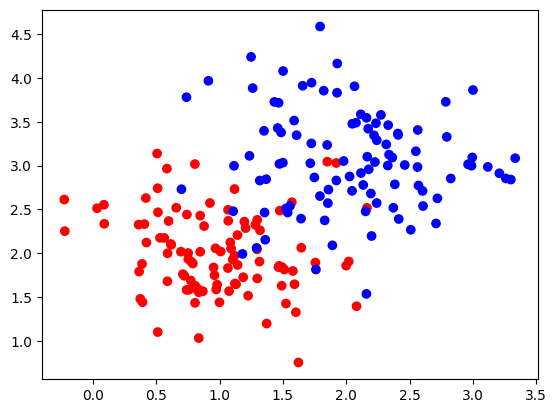

In [2]:
def qwerties(A, B, s, n):
    x1 = tensor(A) + s * torch.randn((n, 2))
    x2 = tensor(B) + s * torch.randn((n, 2))
    c = ["r"] * n + ["b"] * n
    y = torch.vstack((torch.zeros(n)[:, None], torch.ones(n)[:, None])).float()
    return torch.vstack((x1, x2)), y, c
X, y, c = qwerties([1, 2], [2, 3], 0.5, 100)
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [3]:
import torch
from torch import nn, optim, tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset, RandomSampler
from torchvision import datasets, transforms as T
import matplotlib.pyplot as plt
import numpy as np


def createdatanet(X, y, momentum=0, batch_size=None, device="cuda"):
    if len(X) != len(y):
        raise ValueError("lengths unequal")
    if batch_size == None:
        batch_size = len(X)
    dataset = TensorDataset(X, y)
    sampler = RandomSampler(
        dataset,
        generator=torch.Generator().manual_seed(0),
    )
    loader = DataLoader(
        dataset,
        sampler=sampler,
        pin_memory=device == "cuda",
        batch_size=batch_size,
    )
    torch.manual_seed(42)
    net = nn.Sequential(
        nn.Linear(2,256),
        nn.ReLU(),
        nn.Linear(256,1)
    ).to(device)
    # net = nn.Linear(2, 1, bias=False).to(device)
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=momentum)
    return net, lossfun, optimizer, loader


def printnet(net):
    for name, param in net.named_parameters():
        print(name, param)


# GD
net1, lossfun1, optimizer1, loader1 = createdatanet(X, y)
# GD w momentum
net2, lossfun2, optimizer2, loader2 = createdatanet(X, y, momentum=0.5)
# SGD
net3, lossfun3, optimizer3, loader3 = createdatanet(X, y, batch_size=100)
# GD w momentum
net4, lossfun4, optimizer4, loader4 = createdatanet(X, y, momentum=0.5, batch_size=100)


printnet(net1)
printnet(net2)
printnet(net3)
printnet(net4)


def comparenets(net1, net2):
    boo = tensor(True)
    for param1, param2 in zip(net1.parameters(), net2.parameters()):
        boo = (param1 == param2).all()
    print(boo)


def compareloaders(loader1, loader2):
    boo = tensor(True)
    indices = torch.zeros(len(loader1))
    for (X1, y1), (X2, y2) in zip(loader1, loader2):
        boo = boo and (X1 == X2).all() and (y1 == y2).all()
        torch.where(X1 == X)[0].unique()
    print(boo)
    print((indices.unique() == indices).all())


comparenets(net1, net2)
compareloaders(loader1, loader2)


def train(net, lossfun, optimizer, loader, numepochs=2, device="cuda"):
    xs = torch.zeros(1, 2)
    for _ in range(numepochs):
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            x_ = list(net2.parameters())[0].data.cpu()
            xs = torch.vstack((xs, x_))
            y_hat = net(X)
            loss = lossfun(y_hat, y)
            optimizer.zero_grad(True)
            loss.backward()
            optimizer.step()
    return xs


def plottrajectory(xs, c, label):
    plt.plot(xs[:, 0], xs[:, 1], c=c, label=label)

0.weight Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802],
        [-0.3258, -0.0829],
        [-0.2872,  0.4691],
        [-0.5582, -0.3260],
        [-0.1997, -0.4252],
        [ 0.0667, -0.6984],
        [ 0.6386, -0.6007],
        [ 0.5459,  0.1177],
        [-0.2296,  0.4370],
        [ 0.1102,  0.5713],
        [ 0.0773, -0.2230],
        [ 0.1900, -0.1918],
        [ 0.2976,  0.6313],
        [ 0.4087, -0.3091],
        [ 0.4082,  0.1265],
        [ 0.3591, -0.4310],
        [-0.7000, -0.2732],
        [-0.5424,  0.5802],
        [ 0.2037,  0.2929],
        [ 0.2236, -0.0123],
        [ 0.5534, -0.5024],
        [ 0.0445, -0.4826],
        [ 0.2180, -0.2435],
        [ 0.2167, -0.1473],
        [ 0.5865, -0.4191],
        [-0.4217,

In [4]:
len(loader1),len(loader2),len(loader3),len(loader4)

(1, 1, 2, 2)

In [5]:
# %%
xs1 = train(
    net1,
    lossfun1,
    optimizer1,
    loader1,
)
xs2 = train(
    net2,
    lossfun2,
    optimizer2,
    loader2,
)
xs3 = train(
    net3,
    lossfun3,
    optimizer3,
    loader3,
)
xs4 = train(
    net4,
    lossfun4,
    optimizer4,
    loader4,
)

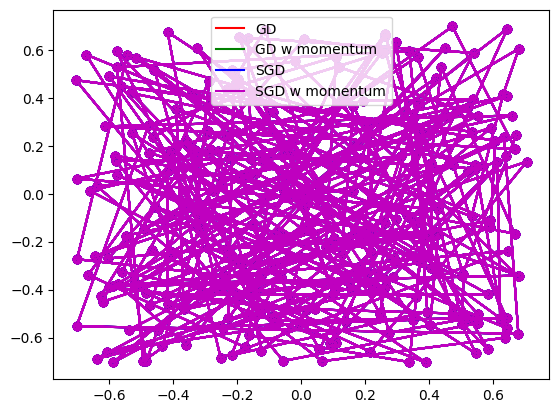

In [6]:
plt.plot(xs1[:, 0], xs1[:, 1], c="r", label="GD")
plt.scatter(xs1[:, 0], xs1[:, 1], c="r")
plt.plot(xs2[:, 0], xs2[:, 1], c="g", label="GD w momentum")
plt.scatter(xs2[:, 0], xs2[:, 1], c="g")
plt.plot(xs3[:, 0], xs3[:, 1], c="b", label="SGD")
plt.scatter(xs3[:, 0], xs3[:, 1], c="b")
plt.plot(xs3[:, 0], xs3[:, 1], c="m", label="SGD w momentum")
plt.scatter(xs3[:, 0], xs3[:, 1], c="m")
plt.legend()
plt.show()

In [ ]:
wholedataset = datasets.MNIST(
    "../data",
    transform=T.Compose(
        [
            T.ToTensor(),
            T.Lambda(lambda x: torch.flatten(x)),
        ],
    ),
    target_transform=T.Compose(
        [
            T.Lambda(lambda x: tensor(x)),
            T.Lambda(lambda x: F.one_hot(x,10)),
            T.Lambda(lambda x: x.float()),
        ],
    ),
)
subset_length = 1000
indices = np.random.choice(len(wholedataset),1000)
dataset = Subset(wholedataset, indices)

def createnet(device):
    torch.manual_seed(0)
    net = nn.Sequential(nn.Linear(784, 32), nn.ReLU(), nn.Linear(32, 10)).to(device)
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    return net, lossfun, optimizer


def comparenets(model1: nn.Module, model2: nn.Module):
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        print((param1.data == param2.data).all())
def getx(numepochs, numbatches):
    return torch.linspace(1, numepochs, numbatches*numepochs)

In [ ]:
# dataloader = DataLoader(dataset, batch_size=1100, shuffle=False)
# X,y = next(iter(dataloader))
# X.shape, y.shape, X.dtype, y.dtype

In [ ]:
def train(dataset, mini_batch_size=None, numepochs=2):
    wholeBatch = mini_batch_size == None
    device = "cuda" if torch.cuda.is_available() else "cpu"
    loaderwhole = DataLoader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        pin_memory=device == "cuda",
    )
    if wholeBatch:
        loader = loaderwhole
    else:
        loaderminibatch = DataLoader(
            dataset,
            batch_size=mini_batch_size,
            shuffle=False,
            pin_memory=device == "cuda",
        )
        loader = loaderminibatch
    numbatches = len(loader)
    losses = torch.zeros(numbatches * numepochs)
    x = getx(numepochs, numbatches)

    net, lossfun, optimizer = createnet(device)
    for i in range(numepochs):
        for j, (X, y) in enumerate(loader):
            if not wholeBatch:
                net.eval()
                with torch.no_grad():
                    X, y = next(iter(loaderwhole))    
                    X, y = X.to(device), y.to(device)
                    y_hat = net(X)
                    loss4wholebatch = lossfun(y_hat, y)
            net.train()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss4batch = lossfun(y_hat, y)
            optimizer.zero_grad(True)
            loss4batch.backward()
            optimizer.step()
            losses[i * numbatches + j] = loss4batch.item() if wholeBatch else loss4wholebatch.item()
    return x, losses, numbatches

In [ ]:
x1,losses1, numbatches1 = train(dataset, None)
x2,losses2, numbatches2 = train(dataset, subset_length//5)

In [ ]:
plt.plot(x1,losses1, c="g")
plt.plot(x2,losses2, c="b")
plt.legend([f"{numbatches1}-batch(es)",f"{numbatches2}-batch(es)"])
plt.show()

In [ ]:
x1,x2

In [ ]:
import numpy as np

In [ ]:
X = np.array(
    [
        [2,-1],
        [-1,3],
    ]
)
w = np.array([1,0])
v = np.array([0,0])
y = np.array([3,1])

In [ ]:
def update(w,v):
    g = (w @ X - y) @ X
    v = 0.8*v-0.2*g
    w=w+v
    return w,v

In [ ]:
for i in range(3):
    w,v = update(w,v)
    print(i,w,v)

In [ ]:
optim = optim.SGD(model.parameters(),lr=0.2,momentum=-4)
optim.state_dict()